<h3>This is KNN implementation submitted as Task-1 for Week-1 of Supervised Learning Course</h3>
<h5>Import the required libraries required for the exercise </h5>

In [1]:
import numpy as np
import pandas as pd

<h6>Import arff from scipy to read the train set given in arff</h6>
<p>Read the dataset and type cast it as pandas dataframe and observe the dataset first few instances</p>

In [26]:
from scipy.io import arff

data = arff.loadarff("trainProdSelection.arff")

df = pd.DataFrame(data[0])

In [27]:
df.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,b'student',b'spend>saving',6.0,40.0,13.62,3.2804,b'C1'
1,b'student',b'spend>saving',11.0,21.0,15.32,2.0232,b'C1'
2,b'student',b'spend>saving',7.0,64.0,16.55,3.1202,b'C1'
3,b'student',b'spend>saving',3.0,47.0,15.71,3.4022,b'C1'
4,b'student',b'spend>saving',15.0,10.0,16.96,2.2825,b'C1'


In [28]:
df.shape

(186, 7)

In [29]:
# df.Vacation.min()

In [30]:
df.label.unique()

array([b'C1', b'C2', b'C3', b'C4', b'C5'], dtype=object)

<h2>Data Pre-Processing</h2>
<p style="font-size:120%;">As we can observe.The dataset contains bytes in some of the columns.So,We have to decode it to UTF-8 format.Only columns that need to be decoded are <em>Type,LifeStyle,Label</em></p>

In [31]:
df.Type = df.Type.str.decode("utf-8")
df.LifeStyle = df.LifeStyle.str.decode("utf-8")
df.label =  df.label.str.decode("utf-8")

In [32]:
df.head(5)

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend>saving,6.0,40.0,13.62,3.2804,C1
1,student,spend>saving,11.0,21.0,15.32,2.0232,C1
2,student,spend>saving,7.0,64.0,16.55,3.1202,C1
3,student,spend>saving,3.0,47.0,15.71,3.4022,C1
4,student,spend>saving,15.0,10.0,16.96,2.2825,C1


In [46]:
df.Type.value_counts()

engineer     49
professor    39
student      38
doctor       37
librarian    23
Name: Type, dtype: int64

<p style="font-size:110%;">Since,the data has been decoded from byte to pandas object.Let's observe the distribution of continuous varibales in the training set</p>

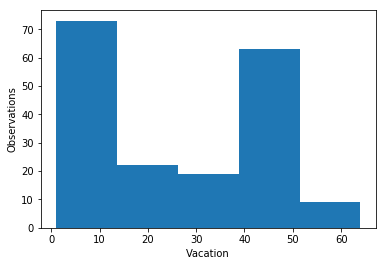

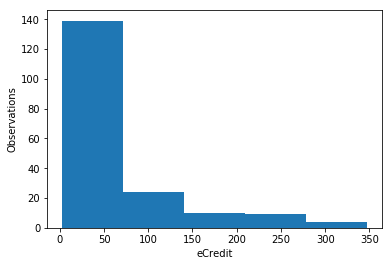

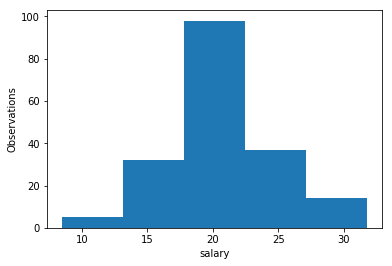

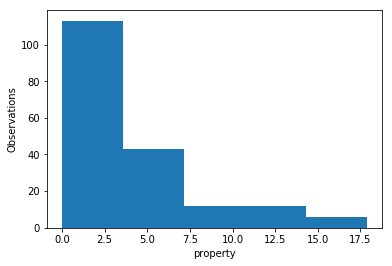

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
for i in ["Vacation","eCredit","salary","property"]:
    plt.hist(df[i],bins=5)
    plt.xlabel(i)
    plt.ylabel("Observations")
    plt.show()

<p style="font-size=200%">-->The distribution for eCredit and property are skewed.So,we need to make them distributed properly.Here feature scaling will help the dataset to be in similar ranges</p>

In [39]:
minValues1 = [df['Vacation'].min(),df.eCredit.min(),df.salary.min(),df.property.min()]
maxValues1 = [df.Vacation.max(),df.eCredit.max(),df.salary.max(),df.property.max()]

In [40]:
df.Vacation=df['Vacation'].apply(lambda x : (x-minValues1[0])/(maxValues1[0]-minValues1[0]))

df.eCredit=df['eCredit'].apply(lambda x : (x-minValues1[1])/(maxValues1[1]-minValues1[1]))

df.salary=df['salary'].apply(lambda x : (x-minValues1[2])/(maxValues1[2]-minValues1[2]))

df.property=df['property'].apply(lambda x : (x-minValues1[3])/(maxValues1[3]-minValues1[3]))

 <h4>Once,We have normalized the columns.And understand the distribution after feature scaling</h4>

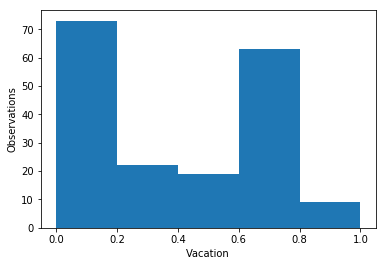

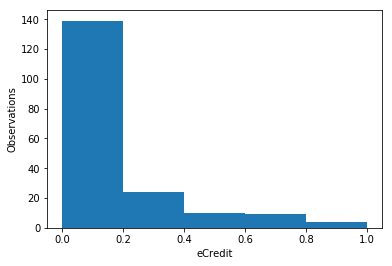

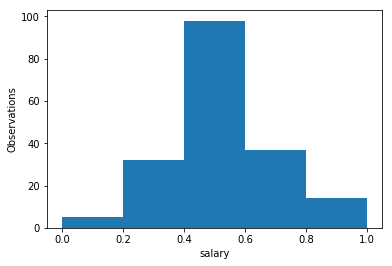

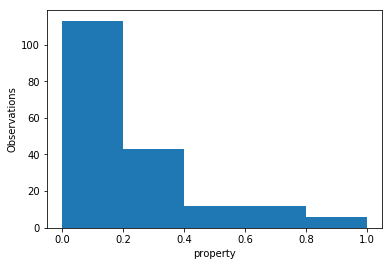

In [42]:
for i in ["Vacation","eCredit","salary","property"]:
    plt.hist(df[i],bins=5)
    plt.xlabel(i)
    plt.ylabel("Observations")
    plt.show()

<h3>Inspite of feature scaling the data is still skewed.property and eCredit are showing bias.Even though,Feature scaling is a good normalization technique.It won't help us in building a good model in this scale</h3>

<Figure size 432x288 with 0 Axes>

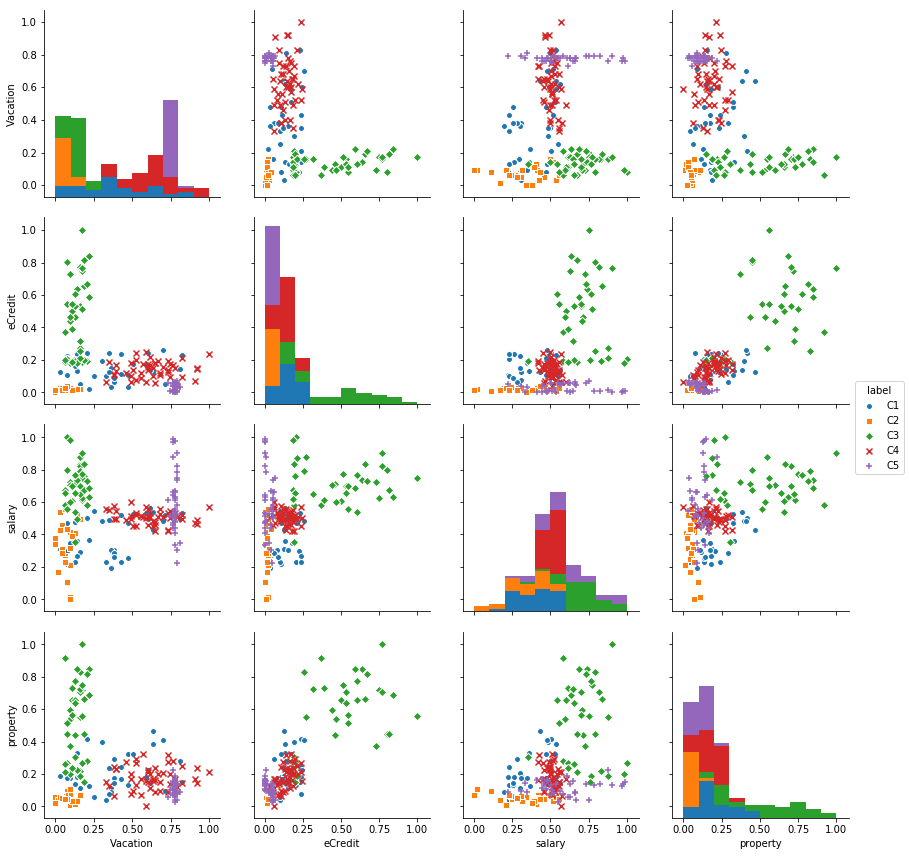

In [43]:
import seaborn as sns
train_df = df.copy()
plt.figure()
sns.pairplot(train_df, hue = 'label', size=3, markers=["o", "s", "D","x","+"])
plt.show()

<h5>From the task description in finding the similarities which as the distances between the each instances.Therefore,to compute the distances for symbollic attributes using the similarity matrix provided </h5>

In [44]:
similarityMatrix = pd.read_excel("similaritymatrix.xls")

<h3>As the similarity matrix consists of two categorical variables.We need extract customer type and life style similarity matrix and remove unneccesary noise from the data</h3>

In [47]:
similarityMatrix

,student,engineer,librarian,professor,doctor
student,1,0,0,0,0.0
engineer,0,1,0,0,0.0
librarian,0,0,1,0,0.0
professor,0,0,0,1,0.0
doctor,0,0,0,0,1.0
NaN,NaN,NaN,NaN,NaN,NaN
NaN,spend<<saving,spend<saving,spend>saving,spend>>saving,NaN
spend<<saving,1,0,0,0,NaN
spend<saving,0,1,0,0,NaN
spend>saving,0,0,1,0,NaN


In [48]:
customer_type=similarityMatrix[:5]
lifeStyle = similarityMatrix[7:]

In [49]:
lifeStyle

,student,engineer,librarian,professor,doctor
spend<<saving,1,0,0,0,NaN
spend<saving,0,1,0,0,NaN
spend>saving,0,0,1,0,NaN
spend>>saving,0,0,0,1,NaN


In [50]:
lifeStyle.columns = ["spend<<saving","spend<saving","spend>saving","spend>>saving","None"]

In [51]:
lifeStyle.drop(['None'],axis=1)

,spend<<saving,spend<saving,spend>saving,spend>>saving
spend<<saving,1,0,0,0
spend<saving,0,1,0,0
spend>saving,0,0,1,0
spend>>saving,0,0,0,1


In [52]:
customer_type

,student,engineer,librarian,professor,doctor
student,1,0,0,0,0.0
engineer,0,1,0,0,0.0
librarian,0,0,1,0,0.0
professor,0,0,0,1,0.0
doctor,0,0,0,0,1.0


<h3>Anyway,Let's validate the dataset using training set.In order to do this,let's split the training data into trainset and validation set</h3>

In [64]:
df_train = df[:162]
df_valid = df[162:]
df_train.tail()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
157,professor,spend>saving,0.761905,0.005814,0.469504,0.104541,C5
158,professor,spend>saving,0.777778,0.000000,0.335697,0.143885,C5
159,professor,spend>>saving,0.761905,0.005814,0.645476,0.154251,C5
160,professor,spend>>saving,0.777778,0.005814,0.611056,0.186268,C5
161,professor,spend>>saving,0.777778,0.000000,0.476818,0.161874,C5


In [65]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_valid.tail()
df_train.tail()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
157,professor,spend>saving,0.777778,0.000000,0.628696,0.139133,C5
158,professor,spend>saving,0.777778,0.000000,0.335697,0.143885,C5
159,professor,spend>saving,0.761905,0.011628,0.874798,0.221206,C5
160,engineer,spend<<saving,0.603175,0.139535,0.557275,0.213297,C4
161,doctor,spend>saving,0.619048,0.168605,0.530169,0.110916,C4


<h3>The Following is a knn implementation for the task</h3>

In [62]:
import operator
class knn(object):
    
    def __init__(self,neighbors=None,matrix1=None,matrix2=None,minV=None,maxV=None):
        self.trainData_X = None
        self.trainData_Y = None
        self.neighbors = neighbors
        self.similaritiesMatrix1 = matrix1
        self.similaritiesMatrix2 = matrix2
        self.maxValues = maxV
        self.minValues = minV
        
    def fit(self,X,Y):
        self.trainData_X = X
        self.trainData_Y = Y
    
    def similarities(self,x1,x2):     
        d= np.square(self.similaritiesMatrix1[x1[0]][x2[0]])
        d+= np.square(self.similaritiesMatrix2[x1[1]][x2[1]])
        for i in range(2,len(x1)):
            mn,mx = self.minValues[str(i)],self.maxValues[str(i)]
            if mx !=None or mn!=None:
                d+= np.square((x1[i]-x2[i])/(mx-mn))
        return np.sqrt(d)   
    
    def Votes(self,lst):
        mode = [None]
        mx=0
        for i in range(len(lst)):
            c=0
            for j in range(len(lst)):
                if lst[i]==lst[j]:
                    c+=1
            if mx<c:
                if lst[i] not in mode:
                    mode[0] = lst[i]
                mx = c
            elif mx==c:
                if lst[i] not in mode:
                    mode.append(lst[i])
        if not mode[0]:
            return lst
        return mode[0]
     
    def predict(self,X_test,Y_test):
        if not self.neighbors:
            self.neighbors = 3
        predictClass = []
        for e in range(len(X_test)):
            distances={}
            for x_i in range(len(self.trainData_X)):
                dist = self.similarities(X_test[e],self.trainData_X[x_i])
                distances[x_i] = dist
            sorted_d = sorted(distances.items(),key=operator.itemgetter(1))
            kneighbors = [self.trainData_Y[x[0]] for x in sorted_d[:self.neighbors]]
            kVotes = self.Votes(kneighbors)
            predictClass.append(kVotes)            
        return predictClass

<h4>We have randomized the dataset in order to improve the accuracy and reduce bias towards a particular class</h4>

In [63]:
minValues = {"1":None,"2":None,"3":df['Vacation'].min(),"4":df.eCredit.min(),"5":df.salary.min(),"6":df.property.min()}
maxValues = {"1":None,"2":None,"3":df.Vacation.max(),"4":df.eCredit.max(),"5":df.salary.max(),"6":df.property.max()}

In [66]:
model_valid = knn(neighbors=3,matrix1=customer_type,matrix2=lifeStyle,minV=minValues,maxV=maxValues)
model_valid.fit(df_train.values[:,[0,1,2,3,4,5]],df_train.values[:,[6]])

In [67]:
pred_train = model_valid.predict(df_train.values[:,[0,1,2,3,4,5]],df_train.values[:,[6]])

In [68]:
pred_valid=model_valid.predict(df_valid.values[:,[0,1,2,3,4,5]],df_valid.values[:,[6]])

In [69]:
a = pd.Series(pred_valid).value_counts()

In [70]:
b = pd.Series(pred_train).value_counts()

In [71]:
a

[C2]    9
[C4]    6
[C3]    4
[C5]    4
[C1]    1
dtype: int64

In [73]:
from sklearn.metrics import confusion_matrix

In [ ]:
# plt.imshow()

In [72]:
b/len(df_train)

[C4]    0.469136
[C1]    0.283951
[C2]    0.179012
[C3]    0.037037
[C5]    0.030864
dtype: float64

In [28]:
a/len(df_valid)

[C2]    0.375000
[C4]    0.250000
[C3]    0.166667
[C5]    0.166667
[C1]    0.041667
dtype: float64

In [74]:
model_valid1 = knn(neighbors=3,matrix1=customer_type,matrix2=lifeStyle,minV=minValues,maxV=maxValues)
model_valid1.fit(df_train.values[:,[0,1,2,3,4]],df_train.values[:,[6]])

In [75]:
pred_prp=model_valid1.predict(df_train.values[:,[0,1,2,3,4]],df_train.values[:,[6]])
c = pd.Series(pred_prp).value_counts()

In [76]:
c/len(pred_prp)

[C4]    0.506173
[C1]    0.185185
[C2]    0.185185
[C3]    0.104938
[C5]    0.018519
dtype: float64

<h4>Read the test dataset and preprocess it as performed on the training dataset</h4>

In [77]:
dataTest = arff.loadarff("testProdSelection.arff")

In [78]:
df_test = pd.DataFrame(dataTest[0])

In [79]:
minValues2 = [df_test['Vacation'].min(),df_test.eCredit.min(),df_test.salary.min(),df_test.property.min()]
maxValues2 = [df_test.Vacation.max(),df_test.eCredit.max(),df_test.salary.max(),df_test.property.max()]

In [80]:
df_test.Type = df_test.Type.str.decode('utf-8')

In [81]:
df_test.LifeStyle = df_test.LifeStyle.str.decode('utf-8')
df_test.label = df_test.label.str.decode('utf-8')

In [82]:
df_test.head(5)

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend<saving,12.0,19.0,14.7900,3.7697,C1
1,student,spend>>saving,29.0,10.0,16.1900,2.4839,C1
2,student,spend<<saving,28.0,60.0,15.4600,1.1885,C1
3,engineer,spend>saving,15.0,41.0,21.2600,1.4379,C1
4,librarian,spend<saving,2.0,9.0,19.7207,0.6913,C1


In [83]:
df_test.eCredit=df_test['eCredit'].apply(lambda x : (x-minValues2[1])/(maxValues2[1]-minValues2[1]))

df_test.salary=df_test['salary'].apply(lambda x : (x-minValues2[2])/(maxValues2[2]-minValues2[2]))

df_test.Vacation=df_test['Vacation'].apply(lambda x : (x-minValues2[0])/(maxValues2[0]-minValues2[0]))

df_test.property=df_test['property'].apply(lambda x : (x-minValues2[3])/(maxValues2[3]-minValues2[3]))

In [84]:
x_test = df_test.values

In [85]:
x_test.shape

(21, 7)

In [86]:
print(minValues)
print(maxValues)

{'1': None, '2': None, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0}
{'1': None, '2': None, '3': 1.0, '4': 1.0, '5': 1.0, '6': 1.0}


<h4>Make knn object.Fit the training set and predict on the test set and finally evaluate</h4>

In [87]:
x = df.values

X = x[:,[0,1,2,3,4]]

Y=x[:,6]

In [88]:
y_test = x_test[:,6]

In [89]:
x_test = x_test[:,[0,1,2,3,4]]

In [90]:
model = knn(neighbors=5,matrix1=customer_type,matrix2=lifeStyle,minV = minValues,maxV = maxValues)

model.fit(X,Y)

# predValid = model.predict()
predTest = model.predict(x_test,y_test)

In [91]:
df.corr(method="pearson")

,Vacation,eCredit,salary,property
Vacation,1.000000,-0.355139,0.110022,-0.296422
eCredit,-0.355139,1.000000,0.408194,0.830698
salary,0.110022,0.408194,1.000000,0.427750
property,-0.296422,0.830698,0.427750,1.000000


In [92]:
len(predTest)

21

In [93]:
a=pd.Series(y_test).value_counts()

In [94]:
pd.Series(predTest).tolist()

['C2',
 'C2',
 'C2',
 'C4',
 'C5',
 'C1',
 'C2',
 'C1',
 'C3',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C4',
 'C4',
 'C4',
 'C1',
 'C2',
 'C5',
 'C2']

In [95]:
# type(model.trainData_X[0][1])
r=pd.Series(predTest).value_counts()

In [96]:
round((r/len(predTest))*100,2)

C1    33.33
C2    28.57
C4    19.05
C5     9.52
C3     9.52
dtype: float64

In [52]:
from sklearn.metrics import accuracy_score

In [53]:
accuracy_score(y_test,predTest)

0.3333333333333333

<h3>Testing for model Accuracy using sklearn---Only For testing the implementation</h3>

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

In [55]:
temp = df.copy()

In [56]:
test_temp = df_test.copy()

In [57]:
label = preprocessing.LabelEncoder()
temp_Y=temp.label.unique().tolist()

In [58]:
#temp_Y = temp.label.unique().tolist()
test_temp_Y = test_temp.label.unique().tolist()

In [59]:
# a=label.fit(temp.label)
temp_Y


['C1', 'C2', 'C3', 'C4', 'C5']

In [60]:
# list(a.classes_)
encoder = preprocessing.LabelEncoder()

In [61]:
test_encoder= preprocessing.LabelEncoder()

In [62]:
encoder.fit(temp_Y)

LabelEncoder()

In [63]:
test_encoder.fit(test_temp_Y)

LabelEncoder()

In [64]:
temp.label = encoder.transform(temp.label)

In [65]:
test_temp.label = test_encoder.transform(test_temp.label)

In [66]:
test_temp.label.value_counts()

0    21
Name: label, dtype: int64

In [67]:
temp.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend>saving,0.079365,0.107558,0.219960,0.183167,0
1,student,spend>saving,0.158730,0.052326,0.293102,0.112797,0
2,student,spend>saving,0.095238,0.177326,0.346023,0.174200,0
3,student,spend>saving,0.031746,0.127907,0.309882,0.189984,0
4,student,spend>saving,0.222222,0.020349,0.363663,0.127311,0


In [68]:
test_temp.head()

,Type,LifeStyle,Vacation,eCredit,salary,property,label
0,student,spend<saving,0.20,0.058824,0.104637,0.398926,0
1,student,spend>>saving,0.54,0.021008,0.175059,0.243041,0
2,student,spend<<saving,0.52,0.231092,0.138339,0.085992,0
3,engineer,spend>saving,0.26,0.151261,0.430086,0.116229,0
4,librarian,spend<saving,0.00,0.016807,0.352657,0.025714,0


In [69]:
temp_dummy = pd.get_dummies(temp)

In [70]:
test_dummy = pd.get_dummies(test_temp)

In [71]:
print(list(test_dummy))

['Vacation', 'eCredit', 'salary', 'property', 'label', 'Type_doctor', 'Type_engineer', 'Type_librarian', 'Type_professor', 'Type_student', 'LifeStyle_spend<<saving', 'LifeStyle_spend<saving', 'LifeStyle_spend>>saving', 'LifeStyle_spend>saving']


In [72]:
temp_dummy.head()

,Vacation,eCredit,salary,property,label,Type_doctor,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<<saving,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,0.079365,0.107558,0.219960,0.183167,0,0,0,0,0,1,0,0,0,1
1,0.158730,0.052326,0.293102,0.112797,0,0,0,0,0,1,0,0,0,1
2,0.095238,0.177326,0.346023,0.174200,0,0,0,0,0,1,0,0,0,1
3,0.031746,0.127907,0.309882,0.189984,0,0,0,0,0,1,0,0,0,1
4,0.222222,0.020349,0.363663,0.127311,0,0,0,0,0,1,0,0,0,1


In [73]:
test_dummy.head()

,Vacation,eCredit,salary,property,label,Type_doctor,Type_engineer,Type_librarian,Type_professor,Type_student,LifeStyle_spend<<saving,LifeStyle_spend<saving,LifeStyle_spend>>saving,LifeStyle_spend>saving
0,0.20,0.058824,0.104637,0.398926,0,0,0,0,0,1,0,1,0,0
1,0.54,0.021008,0.175059,0.243041,0,0,0,0,0,1,0,0,1,0
2,0.52,0.231092,0.138339,0.085992,0,0,0,0,0,1,1,0,0,0
3,0.26,0.151261,0.430086,0.116229,0,0,1,0,0,0,0,0,0,1
4,0.00,0.016807,0.352657,0.025714,0,0,0,1,0,0,0,1,0,0


In [74]:
knnModel = KNeighborsClassifier(n_neighbors=3)

In [75]:
temp_y = temp_dummy['label']

In [76]:
temp_x = temp_dummy.drop(['label'],axis=1)

In [77]:
test_data = test_dummy.drop(['label'],axis=1)

In [78]:
knnModel.fit(temp_x,temp_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [79]:
predict=knnModel.predict(test_data)

In [80]:
a=pd.Series(predict).value_counts()

In [81]:
round((a/len(predict)),4)

0    0.2857
4    0.1905
2    0.1905
1    0.1905
3    0.1429
dtype: float64

In [83]:
pd.crosstab(index=test_dummy.label,columns=predict)

col_0,0,1,2,3,4
label,,,,,
0,6,4,4,3,4
